In [1]:
%load_ext autoreload

%autoreload 2
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.svm import SVC
 
from sklearn import metrics

from mlxtend.plotting import plot_decision_regions
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from ast import literal_eval

import warnings
import numpy as np
from collections import OrderedDict

from lob_data_utils import lob, db_result, model
from lob_data_utils.svm_calculation import lob_svm
import os
from scipy import stats


sns.set_style('whitegrid')
warnings.filterwarnings('ignore')

In [2]:
data_dir = 'res_svm'
should_savefig = False

In [3]:
results_files = os.listdir(data_dir)
df_res = pd.DataFrame()
for f in results_files:
    if 'csv' not in f:
        continue
    df_res = df_res.append(pd.read_csv(os.path.join(data_dir, f)))

df_res.drop(columns=['Unnamed: 0'], inplace=True)
df_res.head(4)

,C,coef0,f1,features,gamma,kappa,kernel,matthews,precision,recall,...,train_matthews,train_precision,train_recall,train_roc_auc,train_val_f1,train_val_kappa,train_val_matthews,train_val_precision,train_val_recall,train_val_roc_auc
0,0.001,NaN,0.275682,que,0.001,0.0,rbf,0.0,0.210316,0.4,...,0.0,0.503,1.0,0.5,0.268078,0.0,0.0,0.201596,0.4,0.5
1,0.001,NaN,0.275682,que,0.010,0.0,rbf,0.0,0.210316,0.4,...,0.0,0.503,1.0,0.5,0.268078,0.0,0.0,0.201596,0.4,0.5
2,0.001,NaN,0.275682,que,0.100,0.0,rbf,0.0,0.210316,0.4,...,0.0,0.503,1.0,0.5,0.268078,0.0,0.0,0.201596,0.4,0.5
3,0.001,NaN,0.275682,que,1.000,0.0,rbf,0.0,0.210316,0.4,...,0.0,0.503,1.0,0.5,0.268078,0.0,0.0,0.201596,0.4,0.5


In [4]:
df_best_rbf = df_res[df_res['kernel'] == 'rbf'].sort_values(
    by='matthews', ascending=False).groupby('stock').head(1)
df_best_lin = df_res[df_res['kernel'] == 'linear'].sort_values(
    by='matthews', ascending=False).groupby('stock').head(1)
df_best_sig = df_res[df_res['kernel'] == 'sigmoid'].sort_values(
    by='matthews', ascending=False).groupby('stock').head(1)

In [5]:
df_best = df_res.sort_values(by=['matthews', 'train_matthews'], ascending=False).groupby('stock').head(1)

## Distributions

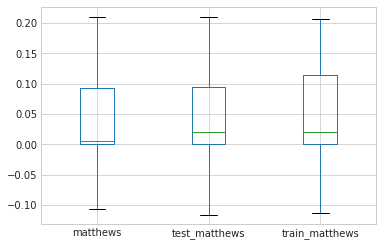

In [6]:
df_res[['matthews', 'test_matthews', 'train_matthews']].boxplot()

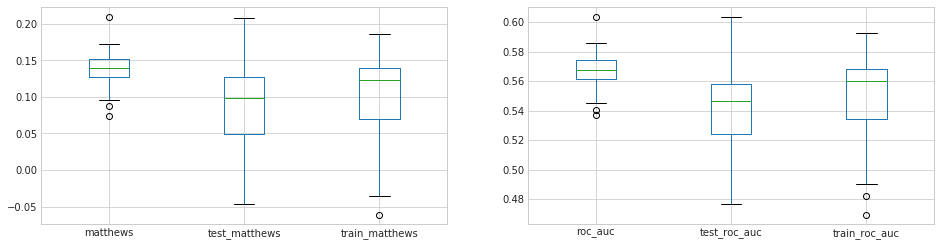

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
df_best[['matthews', 'test_matthews', 'train_matthews']].boxplot(ax=ax1)
df_best[['roc_auc', 'test_roc_auc', 'train_roc_auc']].boxplot(ax=ax2)

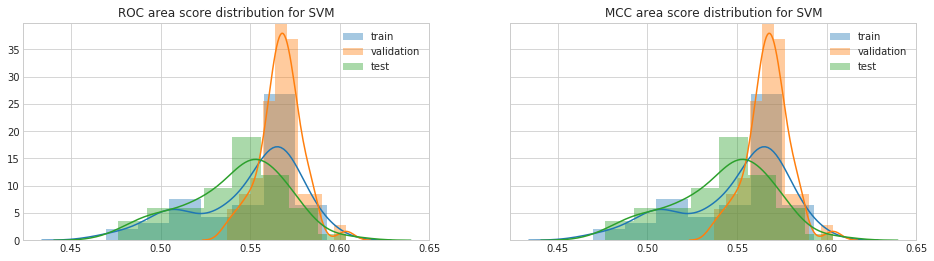

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4), sharey=True)
sns.distplot(df_best[['train_roc_auc']], label='train', ax=ax1)
sns.distplot(df_best[['roc_auc']], label='validation', ax=ax1)
sns.distplot(df_best[['test_roc_auc']], label='test', ax=ax1)
ax1.set_title('ROC area score distribution for SVM')

sns.distplot(df_best[['train_roc_auc']], label='train', ax=ax2)
sns.distplot(df_best[['roc_auc']], label='validation', ax=ax2)
sns.distplot(df_best[['test_roc_auc']], label='test', ax=ax2)
ax2.set_title('MCC area score distribution for SVM')

ax1.legend()
ax2.legend()

### Per kernel

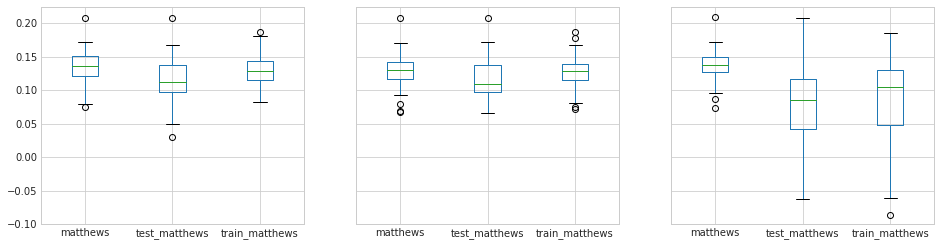

In [9]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 4), sharey=True)
df_best_rbf[['matthews', 'test_matthews', 'train_matthews']].boxplot(ax=ax1)
df_best_lin[['matthews', 'test_matthews', 'train_matthews']].boxplot(ax=ax2)
df_best_sig[['matthews', 'test_matthews', 'train_matthews']].boxplot(ax=ax3)

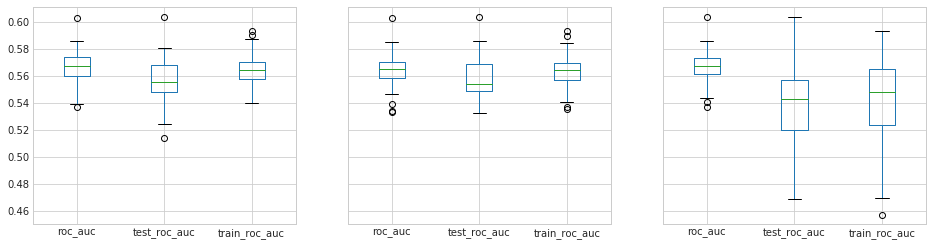

In [10]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 4), sharey=True)
df_best_rbf[['roc_auc', 'test_roc_auc', 'train_roc_auc']].boxplot(ax=ax1)
df_best_lin[['roc_auc', 'test_roc_auc', 'train_roc_auc']].boxplot(ax=ax2)
df_best_sig[['roc_auc', 'test_roc_auc', 'train_roc_auc']].boxplot(ax=ax3)

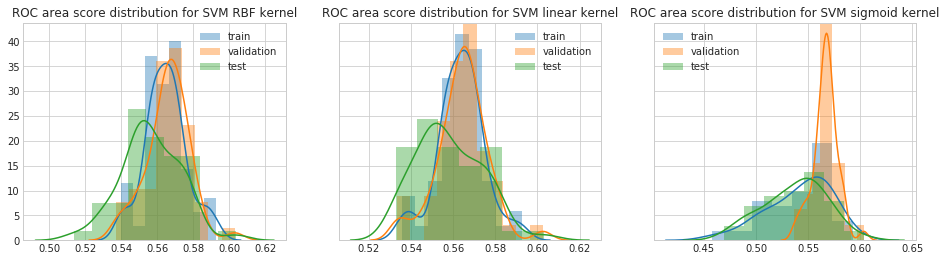

In [11]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 4), sharey=True)
sns.distplot(df_best_rbf[['train_roc_auc']], label='train', ax=ax1)
sns.distplot(df_best_rbf[['roc_auc']], label='validation', ax=ax1)
sns.distplot(df_best_rbf[['test_roc_auc']], label='test', ax=ax1)
ax1.set_title('ROC area score distribution for SVM RBF kernel')

sns.distplot(df_best_lin[['train_roc_auc']], label='train', ax=ax2)
sns.distplot(df_best_lin[['roc_auc']], label='validation', ax=ax2)
sns.distplot(df_best_lin[['test_roc_auc']], label='test', ax=ax2)
ax2.set_title('ROC area score distribution for SVM linear kernel')

sns.distplot(df_best_sig[['train_roc_auc']], label='train', ax=ax3)
sns.distplot(df_best_sig[['roc_auc']], label='validation', ax=ax3)
sns.distplot(df_best_sig[['test_roc_auc']], label='test', ax=ax3)
ax3.set_title('ROC area score distribution for SVM sigmoid kernel')

ax1.legend()
ax2.legend()
ax3.legend()

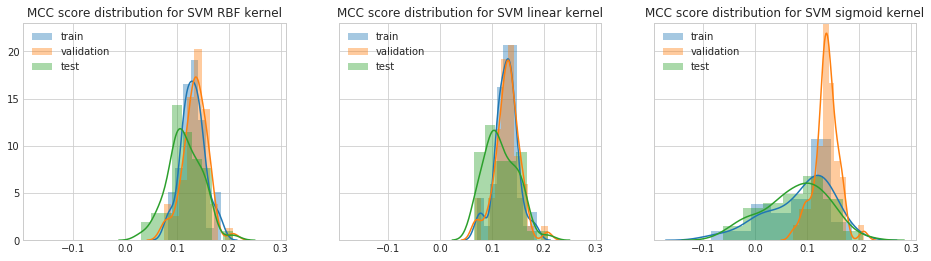

In [12]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 4), sharey=True, sharex=True)
sns.distplot(df_best_rbf[['train_matthews']], label='train', ax=ax1)
sns.distplot(df_best_rbf[['matthews']], label='validation', ax=ax1)
sns.distplot(df_best_rbf[['test_matthews']], label='test', ax=ax1)
ax1.set_title('MCC score distribution for SVM RBF kernel')

sns.distplot(df_best_lin[['train_matthews']], label='train', ax=ax2)
sns.distplot(df_best_lin[['matthews']], label='validation', ax=ax2)
sns.distplot(df_best_lin[['test_matthews']], label='test', ax=ax2)
ax2.set_title('MCC score distribution for SVM linear kernel')

sns.distplot(df_best_sig[['train_matthews']], label='train', ax=ax3)
sns.distplot(df_best_sig[['matthews']], label='validation', ax=ax3)
sns.distplot(df_best_sig[['test_matthews']], label='test', ax=ax3)
ax3.set_title('MCC score distribution for SVM sigmoid kernel')

ax1.legend()
ax2.legend()
ax3.legend()

### Distributions without sigmoid

In [13]:
df_ker = df_res[df_res['kernel'] != 'sigmoid']

df_ker = df_ker.sort_values(by='matthews', ascending=False).groupby('stock').head(1)

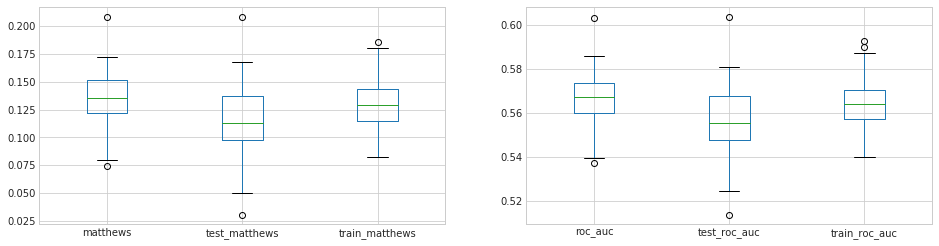

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
df_ker[['matthews', 'test_matthews', 'train_matthews']].boxplot(ax=ax1)
df_ker[['roc_auc', 'test_roc_auc', 'train_roc_auc']].boxplot(ax=ax2)

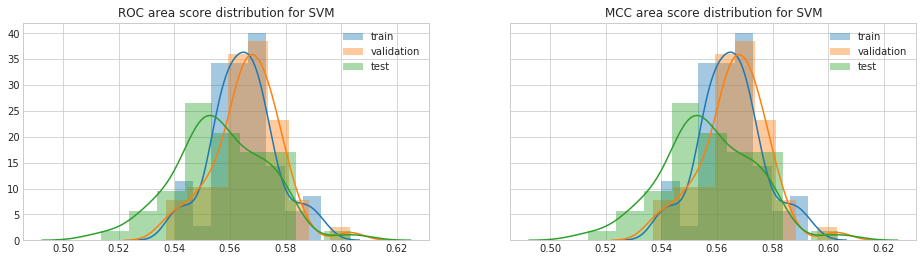

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4), sharey=True)
sns.distplot(df_ker[['train_roc_auc']], label='train', ax=ax1)
sns.distplot(df_ker[['roc_auc']], label='validation', ax=ax1)
sns.distplot(df_ker[['test_roc_auc']], label='test', ax=ax1)
ax1.set_title('ROC area score distribution for SVM')

sns.distplot(df_ker[['train_roc_auc']], label='train', ax=ax2)
sns.distplot(df_ker[['roc_auc']], label='validation', ax=ax2)
sns.distplot(df_ker[['test_roc_auc']], label='test', ax=ax2)
ax2.set_title('MCC area score distribution for SVM')

ax1.legend()
ax2.legend()

## Compare with QUE+LOG

In [16]:
df_log = pd.read_csv('res_log_que.csv')
df_log.head()

,Unnamed: 0,f1,kappa,kernel,matthews,precision,recall,roc_auc,stock,test_f1,...,train_matthews,train_precision,train_recall,train_roc_auc,train_val_f1,train_val_kappa,train_val_matthews,train_val_precision,train_val_recall,train_val_roc_auc
0,9069,0.606592,0.106451,logistic,0.110116,0.560176,0.668642,0.553009,9069,0.596796,...,0.110846,0.562237,0.588394,0.555305,0.570305,0.106012,0.106221,0.562527,0.579022,0.552936
1,9063,0.556315,0.132925,logistic,0.134670,0.587495,0.532457,0.566731,9063,0.548865,...,0.129022,0.566616,0.561535,0.564510,0.537821,0.120971,0.121636,0.560652,0.518837,0.560349
2,1472,0.542305,0.140477,logistic,0.142930,0.590507,0.507180,0.570497,1472,0.639632,...,0.139034,0.576374,0.602151,0.569371,0.587288,0.144617,0.144870,0.574196,0.601283,0.572239
3,9094,0.569562,0.120311,logistic,0.121154,0.560937,0.581269,0.560113,9094,0.581147,...,0.115477,0.558185,0.564589,0.557733,0.564107,0.110154,0.110198,0.557268,0.571155,0.555064
4,9270,0.537700,0.104704,logistic,0.106206,0.575757,0.508286,0.552499,9270,0.569579,...,0.120107,0.560653,0.580020,0.560005,0.557583,0.135759,0.136002,0.565974,0.550238,0.567800


In [17]:
df_best = pd.merge(df_best, df_log, on='stock', suffixes=['', '_log'])
df_best.head()

,C,coef0,f1,features,gamma,kappa,kernel,matthews,precision,recall,...,train_matthews_log,train_precision_log,train_recall_log,train_roc_auc_log,train_val_f1_log,train_val_kappa_log,train_val_matthews_log,train_val_precision_log,train_val_recall_log,train_val_roc_auc_log
0,10.00,1.0,0.636425,que,0.001,0.207807,sigmoid,0.209368,0.603838,0.672972,...,0.185330,0.597856,0.626771,0.592443,0.623368,0.185508,0.186048,0.603145,0.645078,0.592448
1,1000.00,0.1,0.550774,que,0.010,0.168848,sigmoid,0.172523,0.613782,0.501322,...,0.144903,0.575566,0.623071,0.572067,0.602782,0.150690,0.151165,0.582091,0.625088,0.575170
2,1.00,NaN,0.592618,que,0.010,0.171267,rbf,0.172178,0.592604,0.595669,...,0.178407,0.588659,0.608847,0.589132,0.595276,0.174396,0.174598,0.585999,0.605202,0.587151
3,0.01,10.0,0.594850,que,1000.000,0.166712,sigmoid,0.167770,0.577330,0.615727,...,0.153957,0.578272,0.582877,0.576973,0.603824,0.149300,0.149863,0.584112,0.625467,0.574427
4,1000.00,NaN,0.606923,que,0.100,0.165981,rbf,0.167344,0.603181,0.615167,...,0.142180,0.574821,0.611629,0.570850,0.583593,0.140293,0.140473,0.573817,0.593996,0.570068


In [18]:
df_best_lin = pd.merge(df_best_lin, df_log, on='stock', suffixes=['', '_log'])
df_best_rbf = pd.merge(df_best_rbf, df_log, on='stock', suffixes=['', '_log'])
df_best_sig = pd.merge(df_best_sig, df_log, on='stock', suffixes=['', '_log'])

In [19]:
def get_svm(x_train, y_label, kernel=None, C=None, gamma=None, coef0=None):
    clf = SVC(kernel=kernel, C=C, gamma=gamma, coef0=coef0)
    clf.fit(x_train, y_label)
    return clf

def get_svm_params(df, stock):
    df_stock = df[df['stock'] == int(stock)]
    C = df_stock['C'].values[0]
    gamma = df_stock['gamma'].values[0]
    coef0 = df_stock['coef0'].values[0]
    kernel = df_stock['kernel'].values[0]
    return {
        'C': C,
        'gamma': gamma,
        'coef0': coef0,
        'kernel': kernel
    }

def get_log(x_train, y_label):
    clf = LogisticRegression()
    clf.fit(x_train, y_label)
    return clf

In [20]:
stock = '9061'
data_length = 10000
df, df_test = lob.load_prepared_data(stock, data_dir='../gaussian_filter/data', cv=False, length=data_length)

preds = []
preds_log = []
for i in range(0, 30):
    clf = get_svm(df[['queue_imbalance']], df['mid_price_indicator'], **get_svm_params(df_best, stock))
    clf_log = get_log(df[['queue_imbalance']], df['mid_price_indicator'])
    pred = clf.predict(df_test[['queue_imbalance']])
    pred_log = clf_log.predict(df_test[['queue_imbalance']])
    preds.append(metrics.matthews_corrcoef(pred, df_test['mid_price_indicator'].values))
    preds_log.append(metrics.matthews_corrcoef(pred_log, df_test['mid_price_indicator'].values))

In [21]:
df_preds = pd.DataFrame()
df_preds['svm'] = preds
df_preds['log'] = preds_log
df_preds.head()

,svm,log
0,0.03061,0.06052
1,0.03061,0.06052
2,0.03061,0.06052
3,0.03061,0.06052
4,0.03061,0.06052


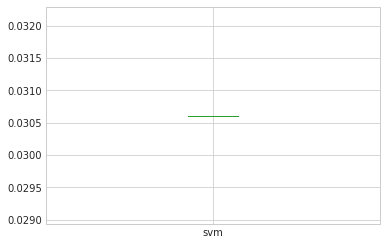

In [22]:
df_preds[['svm']].boxplot()

## McNemar's Test

In [23]:
def perform_mcnemar_test(stock):
    data_length = 10000
    df, df_test = lob.load_prepared_data(str(stock), data_dir='../gaussian_filter/data', 
                                         cv=False, length=data_length)

    clf = get_svm(df[['queue_imbalance']], df['mid_price_indicator'], **get_svm_params(df_best, stock))
    clf_log = get_log(df[['queue_imbalance']], df['mid_price_indicator'])
    pred = clf.predict(df_test[['queue_imbalance']])

    pred_log = clf_log.predict(df_test[['queue_imbalance']])
    #print(metrics.matthews_corrcoef(pred, df_test['mid_price_indicator'].values))
    #print(metrics.matthews_corrcoef(pred_log, df_test['mid_price_indicator'].values))

    [a, b], [c, d] = metrics.confusion_matrix(pred, pred_log)
    
    # print([a, b], [c, d])
    m = ((b - c) ** 2) / (b + c)
    return m

In [24]:
mcnemar_results = []
for stock in df_best['stock'].values:
    mcnemar_results.append(perform_mcnemar_test(stock))
df_best['mcnemar_results'] = mcnemar_results

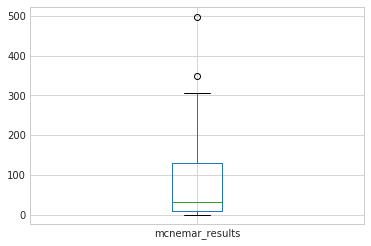

In [25]:
df_best[['mcnemar_results']].boxplot()

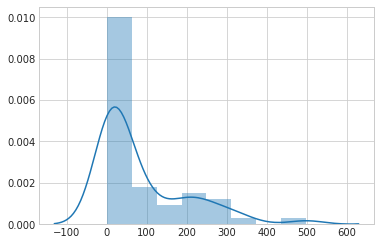

In [26]:
sns.distplot(df_best[['mcnemar_results']])

In [27]:
columns = ['stock', 'kernel'] + [c for c in df_best.columns if 'matthews' in c]
df_best[df_best['mcnemar_results'] < 3.84][columns]

,stock,kernel,matthews,test_matthews,train_matthews,train_val_matthews,matthews_log,test_matthews_log,train_matthews_log,train_val_matthews_log
2,3879,rbf,0.172178,0.113429,0.180155,0.180548,0.162258,0.113455,0.178407,0.174598
5,4799,sigmoid,0.164560,0.135467,0.145563,0.148094,0.166359,0.133334,0.144566,0.145488
15,5836,sigmoid,0.149604,-0.046914,-0.060836,0.132641,0.135863,0.136844,0.139954,0.144384
27,12456,sigmoid,0.138860,0.044843,0.069166,0.142732,0.120783,0.091759,0.133316,0.141260
39,9094,sigmoid,0.127536,0.070248,0.065454,0.104267,0.121154,0.137438,0.115477,0.110198
43,9067,sigmoid,0.122485,0.094088,0.099892,0.097373,0.116487,0.093134,0.101861,0.099216


### Regular comparision of scores

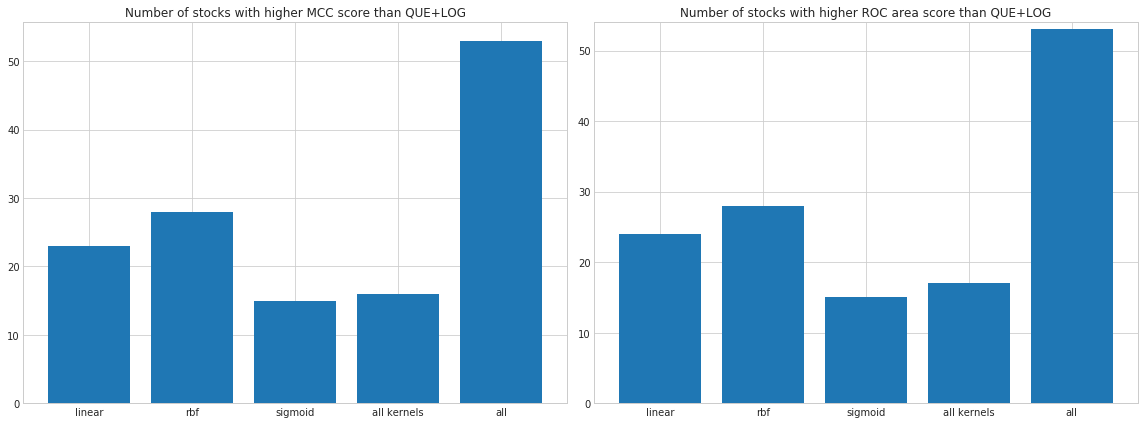

In [28]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

lin = len(df_best_lin[df_best_lin['test_matthews'] > df_best_lin['test_matthews_log']])
rbf = len(df_best_rbf[df_best_rbf['test_matthews'] > df_best_rbf['test_matthews_log']])
sig = len(df_best_sig[df_best_sig['test_matthews'] > df_best_sig['test_matthews_log']])
b = len(df_best[df_best['test_matthews'] > df_best['test_matthews_log']])
ax1.bar(['linear', 'rbf', 'sigmoid', 'all kernels', 'all'], [lin, rbf, sig, b, 53])
ax1.set_title('Number of stocks with higher MCC score than QUE+LOG')

lin = len(df_best_lin[df_best_lin['test_roc_auc'] > df_best_lin['test_roc_auc_log']])
rbf = len(df_best_rbf[df_best_rbf['test_roc_auc'] > df_best_rbf['test_roc_auc_log']])
sig = len(df_best_sig[df_best_sig['test_roc_auc'] > df_best_sig['test_roc_auc_log']])
b = len(df_best[df_best['test_roc_auc'] > df_best['test_roc_auc_log']])
ax2.bar(['linear', 'rbf', 'sigmoid', 'all kernels', 'all'], [lin, rbf, sig, b, 53])
ax2.set_title('Number of stocks with higher ROC area score than QUE+LOG')
plt.ylim(0, 54)
plt.ylim(0, 54)
plt.tight_layout()

## Case Study

In [50]:
stocks = ['9061', '9064', '9265']
df_case = df_res[df_res['kernel'] != 'sigmoid']
df_case = df_case.sort_values(by=['matthews'], ascending=False).groupby('stock').head(1)

In [51]:
columns = ['C', 'kernel', 'train_matthews', 'matthews', 'test_matthews', 'test_matthews_log', 'train_roc_auc', 
           'roc_auc', 'test_roc_auc', 'stock']
df_case = df_case[df_case['stock'].isin(stocks)]
df_case = pd.merge(df_case, df_log[df_log['stock'].isin(stocks)], on='stock', suffixes=['', '_log'])
df_case[columns]

,C,kernel,train_matthews,matthews,test_matthews,test_matthews_log,train_roc_auc,roc_auc,test_roc_auc,stock
0,100.000,rbf,0.113472,0.109940,0.110972,0.097780,0.556599,0.552803,0.555490,9265
1,100.000,rbf,0.087945,0.106657,0.030610,0.060520,0.540060,0.545356,0.513737,9061
2,0.001,linear,0.084338,0.079369,0.067681,0.068588,0.542069,0.539515,0.533787,9064


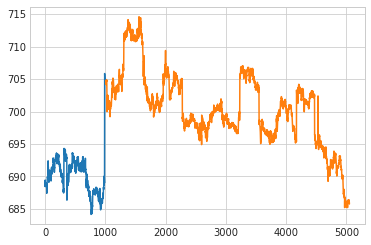

In [57]:
df, df_test = lob.load_prepared_data('9061', data_dir='../gaussian_filter/data/')
df_test['mid_price'].plot()
df['mid_price'].plot()